In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor
import scipy.stats as stats
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import csv

#Eval Plot

In [ ]:
def eval_plot_with_scaling(x_ds, y_ds, C_values, gamma_value=0.1, n_splits=5):
    # Initialize KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Prepare to collect mean MSE and MEE for each C value
    mean_mse = {'train': [], 'test': []}
    std_mse = {'train': [], 'test': []}

    # Perform training and collect errors for each C value
    for C in C_values:
        mse_scores = {'train': [], 'test': []}
        mee_scores = {'train': [], 'test': []}

        for train_index, val_index in kf.split(x_ds):
            X_train_fold, X_val_fold = x_ds.iloc[train_index], x_ds.iloc[val_index]
            y_train_fold, y_val_fold = y_ds.iloc[train_index], y_ds.iloc[val_index]

            # Data scaling
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_fold)
            X_val_scaled = scaler.transform(X_val_fold)

            # Model training
            model = MultiOutputRegressor(SVR(kernel='rbf', C=C, gamma=gamma_value))
            model.fit(X_train_scaled, y_train_fold)

            # Predictions and error calculations
            y_train_pred = model.predict(X_train_scaled)
            y_val_pred = model.predict(X_val_scaled)
            mse_scores['train'].append(mean_squared_error(y_train_fold, y_train_pred))
            mse_scores['test'].append(mean_squared_error(y_val_fold, y_val_pred))

        # Calculate mean and std of errors
        for key in mse_scores:
            mean_mse[key].append(np.mean(mse_scores[key]))
            std_mse[key].append(np.std(mse_scores[key]))

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.fill_between(C_values, np.array(mean_mse['train']) - np.array(std_mse['train']),
                     np.array(mean_mse['train']) + np.array(std_mse['train']), color='blue', alpha=0.2)
    plt.semilogx(C_values, mean_mse['train'], label='Training MSE', color='blue')
    plt.fill_between(C_values, np.array(mean_mse['test']) - np.array(std_mse['test']),
                     np.array(mean_mse['test']) + np.array(std_mse['test']), color='orange', alpha=0.2)
    plt.semilogx(C_values, mean_mse['test'], label='Test MSE', color='orange',linestyle='dashdot',linewidth=1.5)
    plt.xlabel('C value')
    plt.ylabel('MSE')
    plt.title(f'Mean Squared Error for different C values and Gamma ={gamma_value}')
    plt.legend()


#Search and fit

In [ ]:
#load dataset
# do not use zero
df= pd.read_csv('data/ML-CUP23-TR.csv', sep=",", low_memory=False, header = None,  usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13], names=[0,1,2,3,4,5,6,7,8,9,10,'x','y','z'], skiprows=range(0, 7))
df_2= pd.read_csv('data/ML-CUP23-TS.csv', sep=",", low_memory=False, header = None,  usecols=[0,1,2,3,4,5,6,7,8,9,10],  skiprows=range(0, 7))
y_labels=df[['x','y','z']]
features_df = df[[1,2,3,4,5,6,7,8,9,10]]
test_set=df_2[[1,2,3,4,5,6,7,8,9,10]]

In [ ]:
training_x, test_x, training_y, test_y = train_test_split(features_df, y_labels, stratify =None, test_size=0.40, random_state = 42, shuffle=False)

CPU times: user 2.33 s <br>
Sys: 108 ms <br>
Total: 2.44 s <br>
Wall time: 11.7 s

In [ ]:
%%time
# Define the parameter grid
c_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma_values = [0.001, 0.01, 0.05, 0.1, 0.4, 0.7, 1, 3, 5, 8, 10]

# Update the parameter grid to include the SVR parameters
param_grid = {'estimator__regressor__C': c_values, 'estimator__regressor__gamma': gamma_values}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline with StandardScaler and SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', SVR(kernel='rbf'))
])

# Use the pipeline in GridSearchCV with MultiOutputRegressor
grid = GridSearchCV(MultiOutputRegressor(pipeline), param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(training_x, training_y)

best_validation_mse = -grid.best_score_
std_dev = grid.cv_results_['std_test_score'][grid.best_index_]

print(f"The best parameters are {grid.best_params_} with a validation MSE of {best_validation_mse:.2f} and a standard deviation of {std_dev:.2f}")


The best parameters are {'estimator__regressor__C': 1000, 'estimator__regressor__gamma': 0.1} with a validation MSE of 0.35 and a standard deviation of 0.20
CPU times: user 2.33 s, sys: 108 ms, total: 2.44 s
Wall time: 11.7 s


The best parameters are {'estimator__regressor__C': 1000, 'estimator__regressor__gamma': 0.1} with a validation MSE of 0.35 and a standard deviation of 0.20


CPU times: user 6.59 s <br>
Sys: 15.2 ms <br>
Total: 6.6 s <br>
Wall time: 6.7 s

In [ ]:
%%time
def mean_euclidean_error(y_true, y_pred):
    return np.mean(norm(y_true - y_pred, axis=1))
training_mse_scores = []
validation_mse_scores = []
training_mee_scores = []
validation_mee_scores = []

data_X = training_x
data_y = training_y
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(data_X):
    X_train_fold, X_val_fold = data_X.iloc[train_index], data_X.iloc[val_index]
    y_train_fold, y_val_fold = data_y.iloc[train_index], data_y.iloc[val_index]
    scaler = StandardScaler()

    train_x_scaled = scaler.fit_transform(X_train_fold)
    val_scaled = scaler.transform(X_val_fold)#only transform, prevent leakage, use mean and std of training

    model = MultiOutputRegressor(SVR(kernel='rbf',C= 1000,gamma=0.1))
    model.fit(train_x_scaled,y_train_fold)
    train_pred = model.predict(train_x_scaled)
    val_pred = model.predict(val_scaled)

    train_mse = mean_squared_error(y_train_fold, train_pred)
    val_mse = mean_squared_error(y_val_fold, val_pred)
    train_mee = mean_euclidean_error(y_train_fold, train_pred)
    val_mee = mean_euclidean_error(y_val_fold, val_pred)

    training_mse_scores.append(train_mse)
    validation_mse_scores.append(val_mse)
    training_mee_scores.append(train_mee)
    validation_mee_scores.append(val_mee)

avg_train_mse = np.mean(training_mse_scores)
std_train_mse = np.std(training_mse_scores)
avg_val_mse = np.mean(validation_mse_scores)
std_val_mse = np.std(validation_mse_scores)
avg_train_mee = np.mean(training_mee_scores)
std_train_mee = np.std(training_mee_scores)
avg_val_mee = np.mean(validation_mee_scores)
std_val_mee = np.std(validation_mee_scores)

print(f"Training average 5Fold MSE: {avg_train_mse:.4f} stdev: ({std_train_mse:.4f}")
print(f"Validation average 5Fold MSE: {avg_val_mse:.4f} stdev: {std_val_mse:.4f}")
print(f"Training average 5Fold MEE: {avg_train_mee:.4f} stdev: {std_train_mee:.4f}")
print(f"Validation average 5Fold MEE: {avg_val_mee:.4f} stdev: {std_val_mee:.4f}")

Training average 5Fold MSE: 0.0172 stdev: (0.0007
Validation average 5Fold MSE: 0.3480 stdev: 0.1951
Training average 5Fold MEE: 0.1948 stdev: 0.0027
Validation average 5Fold MEE: 0.6629 stdev: 0.0791
CPU times: user 6.59 s, sys: 15.2 ms, total: 6.6 s
Wall time: 6.7 s


CPU times: user 8.48 s <br>
Sys: 26.5 ms <br>
Total: 8.5 s <br>
Wall time: 8.66 s

CPU times: user 8.48 s, sys: 26.5 ms, total: 8.5 s
Wall time: 8.66 s


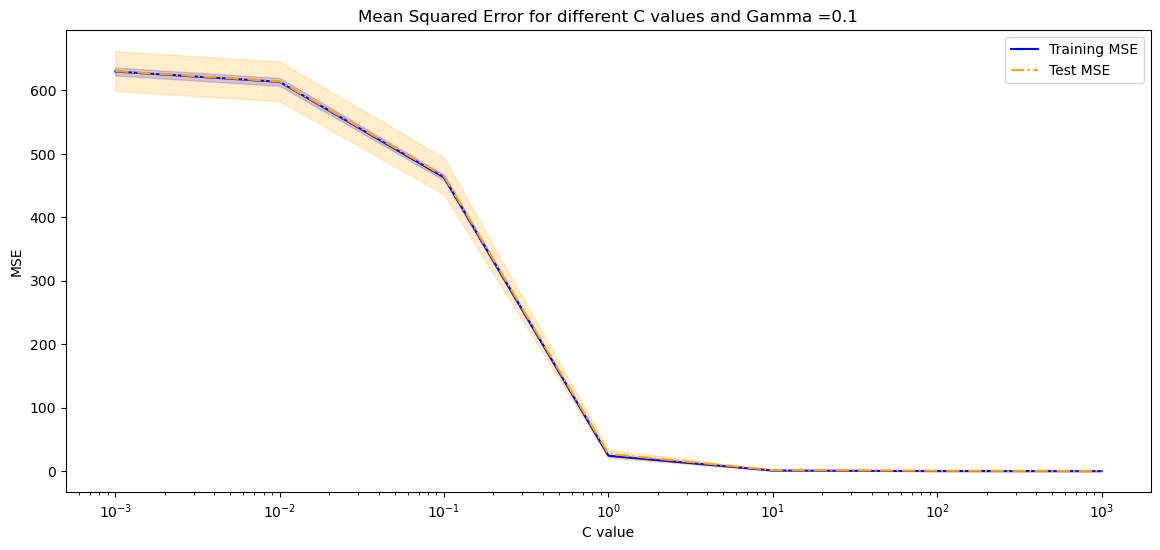

In [ ]:
%%time
# Example usage
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
eval_plot_with_scaling(training_x, training_y, C_values,gamma_value=0.1)


CPU times: user 2.01 s <br>
Sys: 7.16 ms <br>
Total: 2.01 s <br>
Wall time: 2.05 s

In [ ]:
%%time
scaler = StandardScaler()
best_model = MultiOutputRegressor(SVR(kernel='rbf',C= 1000,gamma=0.1))

train_x_scaled = scaler.fit_transform(training_x)
test_x_scaled = scaler.transform(test_x)#only transform, prevent leakage, use mean and std of training

best_model.fit(train_x_scaled,training_y)


CPU times: user 2.01 s, sys: 7.16 ms, total: 2.01 s
Wall time: 2.05 s


MultiOutputRegressor(estimator=SVR(C=1000, gamma=0.1))

In [ ]:

# Predict labels for the training set
train_labels_pred = best_model.predict(train_x_scaled)

# Predict labels for the test set
test_labels_pred = best_model.predict(test_x_scaled)

# Calculate MSE for the training set
train_mse = mean_squared_error(training_y, train_labels_pred)
print(f"Training MSE: {train_mse}")

# Calculate MSE for the test set
test_mse = mean_squared_error(test_y, test_labels_pred)
print(f"Test MSE: {test_mse}")

# Define a function to calculate the Mean Euclidean Error
def mean_euclidean_error(y_true, y_pred):
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

# Calculate MEE for the training set
train_mee = mean_euclidean_error(training_y, train_labels_pred)
print(f"Training MEE: {train_mee}")

# Calculate MEE for the test set
test_mee = mean_euclidean_error(test_y, test_labels_pred)
print(f"Test MEE: {test_mee}")


Training MSE: 0.01826583048752177
Test MSE: 0.3171410869897228
Training MEE: 0.20096875190366778
Test MEE: 0.6571281148942799
CPU times: user 2.05 s, sys: 15.6 ms, total: 2.07 s
Wall time: 2.11 s


Text(0, 0.5, 'Predicted Values')

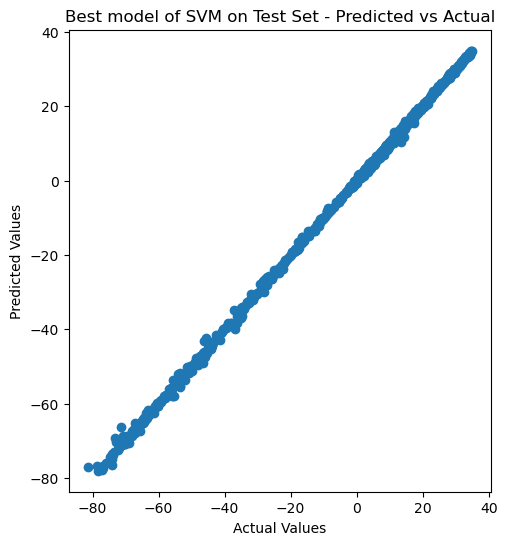

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(test_y, test_labels_pred)
plt.title("Best model of SVM on Test Set - Predicted vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

# Apply to cup

For the CUP we apply an ensemble of 4 SVM and of 1 Neural Network

In [ ]:
blind_test_x = test_set.values

In [ ]:
scaler = StandardScaler()
best_model = MultiOutputRegressor(SVR(kernel='rbf',C= 1000,gamma=0.1))

train_x_scaled = scaler.fit_transform(training_x)

blind_test_x_scaled = scaler.transform(test_x) #only transform, prevent leakage, use mean and std of training

best_model.fit(train_x_scaled,training_y)

# Predict labels for the test set
blind_test_labels_pred = best_model.predict(blind_test_x_scaled)

In [ ]:
blind_test_labels_pred

array([[-31.4126054 ,   7.76334012,  30.65188208],
       [-11.89888747,   9.31518121,  25.08729349],
       [  9.437743  ,   3.54887658,  33.09255952],
       ...,
       [  7.5902562 , -55.27146829,   2.51436962],
       [  5.16840606, -63.3108129 ,  27.89110562],
       [  6.19721198,   8.3452557 ,  12.96222019]])

In [ ]:
def write_predictions_to_csv(predictions, file_name='submission.csv'):
    header = [
        '# Davide Pirolo, Calogero Turco, Giovanni Cupitò',
        '# La volpe e l\'uva',
        '# ML-CUP23',
        '# 30/01/2024'
    ]

    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the header
        for header_row in header:
            writer.writerow([header_row])

        # Write the predictions
        for i, prediction in enumerate(predictions, start=1):
            # Convert each number to a string with full precision
            formatted_prediction = ','.join(repr(num) for num in prediction)
            row = f'{i},{formatted_prediction}'
            writer.writerow([row])

write_predictions_to_csv(blind_test_labels_pred)
